In [0]:
import numpy as np
import math
import re
import pandas as pd
from google.colab import drive
import string
import random
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
import bert
from tensorflow.keras import regularizers
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing import sequence

In [7]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_data_cols = ["id", "keyword", "location", "text"]
train_file_path = "/content/drive/My Drive/ssl/train.csv"
train_label = "target"
train_cols = [train_label] + train_data_cols
test_file_path = "/content/drive/My Drive/ssl/test.csv"
test_cols = train_data_cols

train_df = pd.read_csv(train_file_path, usecols=train_cols)
test_df = pd.read_csv(test_file_path, usecols=test_cols)

train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [0]:
def data_clean(text: str):
	text = re.sub('<[^<]+?>', ' ', text)

	text = text.replace('\\"', '')

	text = text.replace('\n', ' ')

	text = text.replace('\t', ' ')

	text = text.replace('"', '')

	text = text.translate(str.maketrans('', '', string.punctuation))

	text = re.sub(' +', ' ', text)

	text = re.sub('\d+', '0', text)

	text = text.lower()

	return text

test_sentences = [w for w in test_df['text'].values]
train_sentences = [w for w in train_df['text'].values]

data_labels = train_df[train_label].values

In [0]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
def encode_sentence(sentence):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))

train_data_inputs = [encode_sentence(sentence) for sentence in train_sentences]
test_data_inputs = [encode_sentence(sentence) for sentence in test_sentences]

In [0]:
data_with_len = [[sent, data_labels[i], len(sent)] for i, sent in enumerate(train_data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2] )
train_sorted_all = [(sent_lab[0], sent_lab[1]) for sent_lab in data_with_len if sent_lab[2] > 2]

In [0]:
train_all_dataset = tf.data.Dataset.from_generator(lambda: train_sorted_all, output_types=(tf.int32, tf.int32))

In [0]:
test_data_all = [sent for i, sent in enumerate(test_data_inputs)]

test_all_dataset = tf.data.Dataset.from_generator(lambda: test_data_all, output_types=(tf.int32))

BATCH_SIZE = 32
test_all_batched = test_all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None,)))

In [0]:
BATCH_SIZE = 32
train_all_batched = train_all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None,), ()))


NB_BATCHES = math.ceil(len(sorted_all)/BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10

all_dataset.shuffle(NB_BATCHES)
validation_dataset = train_all_batched.take(NB_BATCHES_TEST)
train_dataset = train_all_batched.skip(NB_BATCHES_TEST)

In [0]:
class DCNN(tf.keras.Model):
    def __init__(self, vocab_size, emb_dim=128, nb_filters=50, FFN_units=512, nb_classes=2, dropout_rate=0.1, training=False, name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu")
        self.fourgram = layers.Conv1D(filters=128, kernel_size=4, padding="valid", activation="relu")
        self.pool = layers.GlobalMaxPooling1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="tanh")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.lstm = layers.LSTM(64, kernel_regularizer=regularizers.l2(0.05))

        if nb_classes is 2:
            self.last_dense = layers.Dense(1, activation="sigmoid")
        else:
            self.last_dense = layers.Dense(nb_classes, activation="softmax")
        
    def call(self, inputs, training):

        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_1 = self.dropout(x_1, training)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_2 = self.dropout(x_2, training)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.lstm(x)
        x_4 = self.dropout(x_4, training)

        merged = tf.concat([x_1, x_2, x_3, x_4], axis=-1)
        
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)

        return output

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_121 (Embedding)    (None, None, 300)         9156600   
_________________________________________________________________
lstm_86 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_106 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_191 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_107 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 129       
Total params: 9,392,889
Trainable params: 9,392,889
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


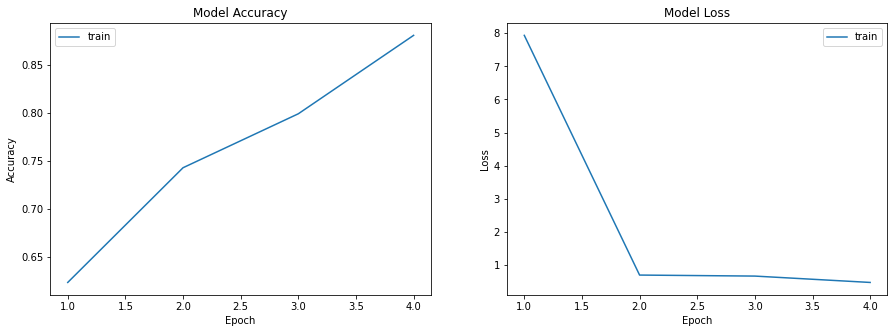

In [462]:
x_train, x_validation, y_train, y_validation = train_test_split(
		train_data_inputs,
		data_labels,
		test_size=0.2,
		random_state=125,
		shuffle=True)
x_train = sequence.pad_sequences(x_train, maxlen=EMB_DIM)
x_validation = sequence.pad_sequences(x_validation, maxlen=EMB_DIM)

x_test = sequence.pad_sequences(test_data_inputs, maxlen=EMB_DIM)

def get_model(vocab_size, emb_dim=128, nb_filters=50, FFN_units=512, nb_classes=2, dropout_rate=0.1, training=False, name="dcnn"):

    model = Sequential()
    model.add(layers.Embedding(vocab_size, emb_dim))
    model.add(layers.LSTM(128, kernel_regularizer=regularizers.l2(0.15)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=128, activation="tanh"))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.summary()

    return model

dcnn = get_model(vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, nb_filters=NB_FILTERS, FFN_units=FNN_units, nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE, training=False, name="dcnn")

dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = dcnn.fit(x_train, y_train,  epochs=NB_EPOCHS, callbacks=[MyCustomCallback(), tensorboard_callback])

eval = dcnn.evaluate(x_validation, y_validation)

plot_model_history(history)

In [0]:
VOCAB_SIZE=len(tokenizer.vocab)
EMB_DIM = 300
NB_FILTERS = 256
FNN_units = 64
NB_CLASSES = 2

DROPOUT_RATE = 0.5

NB_EPOCHS = 4

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
logs_path = "/content/drive/My Drive/ssl/logs"
logdir = os.path.join(logs_path, "log_file")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/3
215/215 [==============================] - 20s 93ms/step - loss: 2.4832 - accuracy: 0.7157
Epoch 2/3
215/215 [==============================] - 20s 92ms/step - loss: 0.3290 - accuracy: 0.8618
Epoch 3/3
23/23 [==============================] - 0s 8ms/step - loss: 0.7252 - accuracy: 0.7514


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


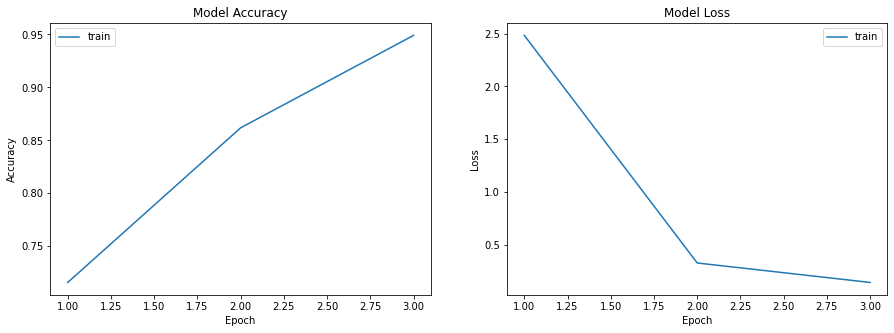

In [415]:
dcnn = DCNN(vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, nb_filters=NB_FILTERS, FFN_units=FNN_units, nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE, training=False, name="dcnn")
# dcnn = get_model(vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, nb_filters=NB_FILTERS, FFN_units=FNN_units, nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE, training=False, name="dcnn")
dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
history = dcnn.fit(train_dataset, epochs=NB_EPOCHS, callbacks=[MyCustomCallback(), tensorboard_callback])

eval = dcnn.evaluate(validation_dataset)

plot_model_history(history)

In [0]:
output_csv_path = "/content/drive/My Drive/ssl/out.csv"
predictions = dcnn.predict(x_train)

with open(output_csv_path, 'w') as file:
    _str = ','.join(['id', 'target'])
    file.write(_str + '\n')

    for index,row in test_df.iterrows():

        _id = row['id']
        prediction = math.floor(predictions[index] *2)
        
        _str = ','.join([str(_id), str(int(prediction))])
        file.write(_str)
        file.write('\n')

In [0]:
checkpoint_path = "/content/drive/My Drive/ssl/"
ckpt = tf.train.Checkpoint(Dcnn=dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkoint restored !")
    
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoc_end(self, epoch, logs=None):
        ckpt.save()
        print("Checkpoint saved at path {}".format(checkpoint_path))

In [0]:
def get_prediction(sentence):
    tokens = encode_sentence(sentence)
    inputs = tf.expand_dims(tokens,0)

    output = dcnn(inputs, training=False)
    sentiment = math.floor(output*2)
    
    return sentiment

In [0]:
output_csv_path = "/content/drive/My Drive/ssl/out.csv"

with open(output_csv_path, 'w') as file:
    _str = ','.join(['id', 'target'])
    file.write(_str + '\n')

    for index,row in test_df.iterrows():
        text = row['text']
        if len(text.split(" ")) < 4:
            text += " 0 0 0"
        
        _id = row['id']
        prediction = get_prediction(text)
        
        _str = ','.join([str(_id), str(int(prediction))])
        file.write(_str)
        file.write('\n')